In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph

from random import randrange, random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.datasets import load_iris, load_wine
from sklearn.tree import export_graphviz
from IPython.display import Image
np.random.seed(42)

import matplotlib as mpl
mpl.rcParams.update({
    'font.size'           : 13,
    'axes.titlesize'      : 'large'
})

## Success Criteria

#### Today I will be successful if I can...
1. Explain bagging in one or two sentences
1. Express why Random Forests work better than traditional Bagging
1. Explain how increasing “n_estimators” will effect the random forest model’s variance

In [151]:
# Load wine data
wine_data = load_wine()

#put dataset into data frame
X = pd.DataFrame(wine_data['data'], columns=wine_data.feature_names)
y = pd.Series(wine_data.target)
# X = data.iloc[:,:]

In [152]:
X

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0


# Part 1

In [153]:
#train test split to enable model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42)

In [154]:
#n_estimators will allow us to look at ensembling various numbers of trees
n_estimators = np.arange(5, 50, 5)

mean_train_accs = []
mean_test_accs = []

for n_trees in n_estimators:
    #create n_trees number of trees ... stored in a list
    trees = [DecisionTreeClassifier(max_depth = 2, random_state=42) for tree in range(n_trees)]
    #fit each tree in list using training data
    fits = [tree.fit(X_train, y_train) for tree in trees]
    
    #predict training and testing classes
    y_hats_train  = [tree.predict(X_train) for tree in trees]
    y_hats_test  = [tree.predict(X_test) for tree in trees]
    
    #chechout training and testing accuracy for each tree in list
    test_accs = [accuracy_score(y_test, y_hat) for y_hat in y_hats_test]
    train_accs = [accuracy_score(y_train, y_hat_train) for y_hat_train in y_hats_train]
    #since we have 5, 10, 15... trees in list we can average 
    #their accuracies to see how increased tree number
    #effects final score in model
    mean_train_accs.append(np.mean(train_accs))
    mean_test_accs.append(np.mean(test_accs))

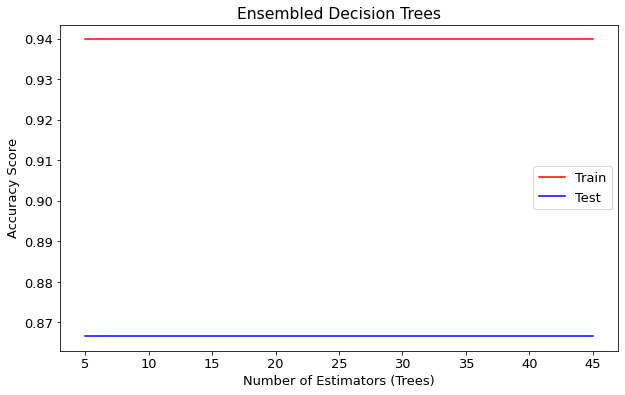

In [155]:
#plot accuracies accross different num trees
plt.figure(figsize=(10,6))
plt.plot(list(n_estimators), mean_train_accs, label = 'Train', c='red', )
plt.plot(list(n_estimators), mean_test_accs, label = 'Test', c = 'blue')
plt.xlabel('Number of Estimators (Trees)')
plt.ylabel('Accuracy Score')
plt.title('Ensembled Decision Trees')
plt.legend();

### Decision tree for Classification
    
    
    
* Consider all binary splits based on a single feature:
    * if the feature is categorical, split on value or not value.
    * if the feature is numeric, split at a threshold: >threshold or <=threshold 
* Consider every possible split of every feature at every value
* Pick the one split that provides the best information gain (entropy/gini impurity)
* Use that split to create two new nodes and consider splitting them on every possible feature/value.
* Stop when all nodes are pure or other stopping conditions like depth limit are met
* Prune trees by merging nodes (ie., canceling a split)


#### So what would two decision trees look like if they were trained on the same data?

In [156]:
#get a nice visual of the decision trees
def get_viz(tree, names = wine_data.target_names, feat_names = wine_data.feature_names):
    #use graphviz to create a decision tree viz
    export_graphviz(tree, out_file='../images/tree.dot', feature_names = feat_names,
                class_names = names,
                rounded = True, proportion = False, precision = 2, filled = True)
    #convert dot to png
    !dot -Tpng ../images/tree.dot -o ../images/tree.png
    return Image('../images/tree.png')

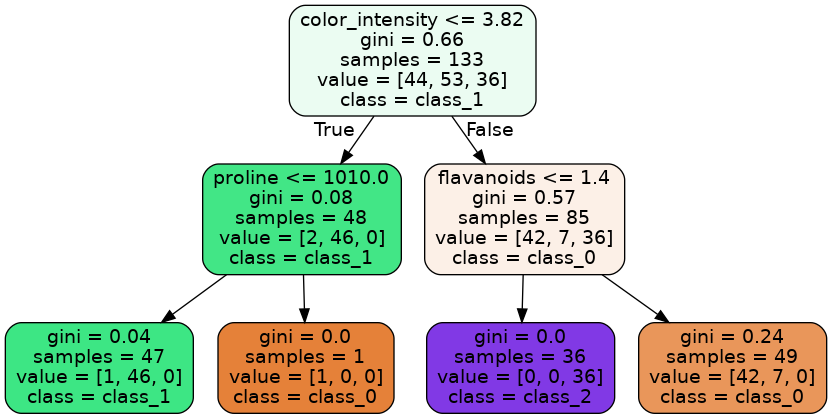

In [157]:
get_viz(trees[0])

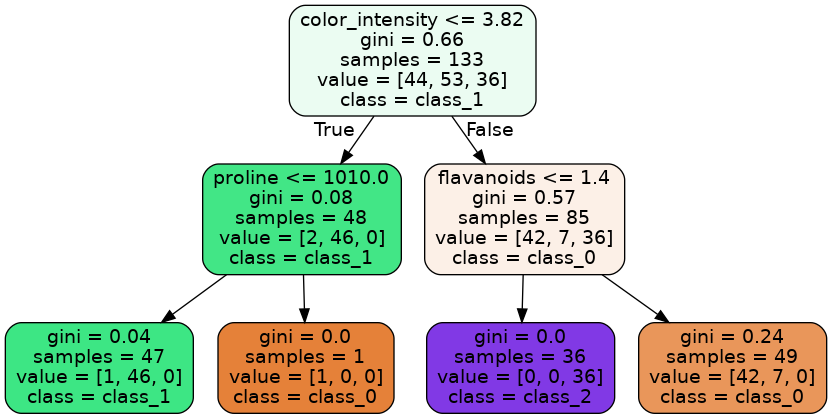

In [158]:
get_viz(trees[1])

We get the exact same tree over and over... so we have an opportunity to get creative and get some variation with our trees.

# Part 2

## Lets Try Bagging

#### Bagging (Bootstrap + Aggregating)
1. take bootstrapped samples of data (n_estimators determine how many samples to bootstrap)
1. train chosen estimator/model continously from the bootstrapped datasets
1. Average/Vote on all of the estimators to return a prediction

In [160]:
#sklearn provides a bagging method
n_estimators = np.arange(5, 100, 5)

train_accs = []
test_accs = []

basetree = DecisionTreeClassifier(max_depth = 2, random_state=42)

for n_trees in n_estimators:
    bag = BaggingClassifier(base_estimator=basetree, n_estimators=n_trees)
    bag.fit(X_train, y_train)
    y_hats_test =  bag.predict(X_test)
    y_hats_train =  bag.predict(X_train)

    
    train_accs.append(accuracy_score(y_hats_train, y_train)) 
    test_accs.append(accuracy_score(y_hats_test, y_test))

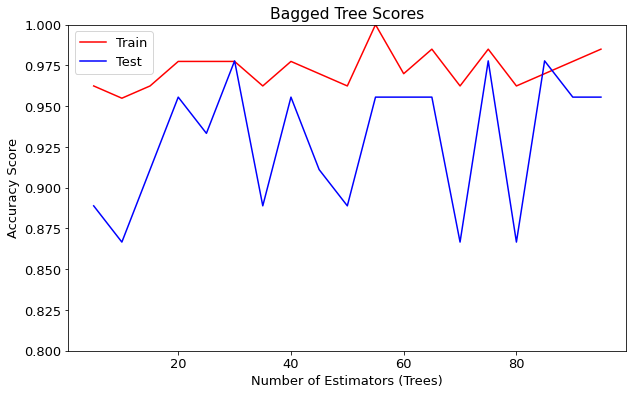

In [161]:
#plot accuracies accross different num trees
plt.figure(figsize=(10,6))
plt.plot(list(n_estimators), train_accs, label = 'Train', c='red', )
plt.plot(list(n_estimators), test_accs, label = 'Test', c = 'blue')
plt.xlabel('Number of Estimators (Trees)')
plt.ylabel('Accuracy Score')
plt.title('Bagged Tree Scores')
plt.ylim(0.8,1)
plt.legend();


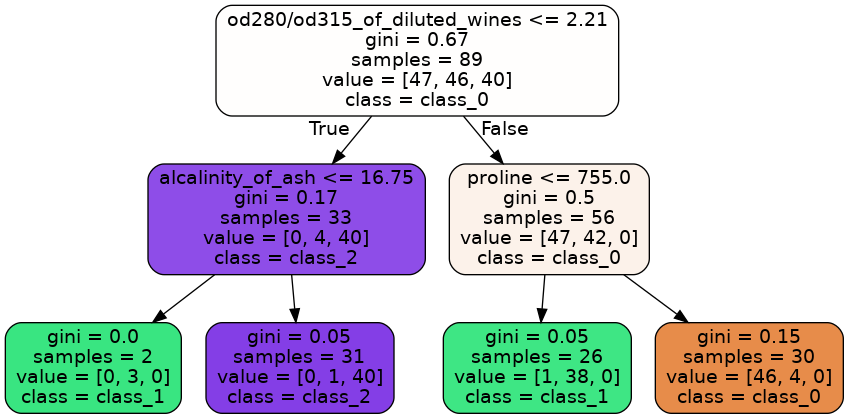

In [162]:
get_viz(bag.estimators_[0])

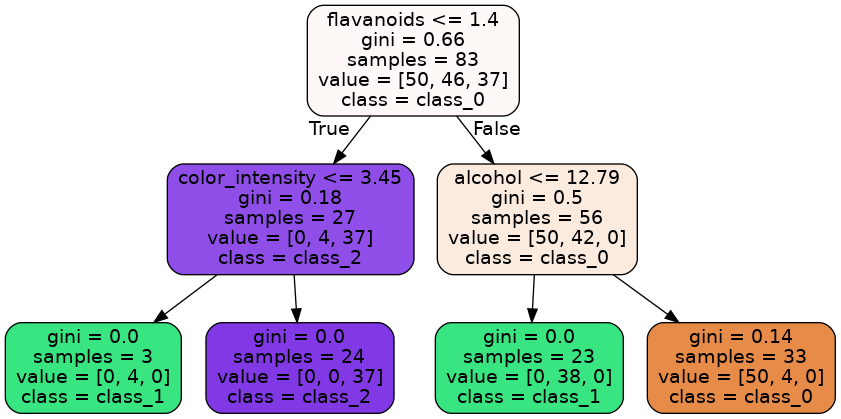

In [163]:
get_viz(bag.estimators_[6])

# Part 3

## Time for a Random Forest

In the above visuals, we see that there is still quite a bit of similarity between our bagged trees. Highly independent trees are going to get us a more accurate ensemble method, this is where the **"Random"** for Random Forest comes in!

To decorrelate the trees even more than bagging, we decide not to consider every feature for each split. The **features are randomly chosen at each split** in each tree. 

The *max_features* parameter helps change the number of considered features. In sklearn, max_features is set to 'auto' which is the square root of the number of features available in the dataset. 




In [183]:
n_estimators = np.arange(1,201)
train_accs_rf = []
test_accs_rf = []
for n_trees in n_estimators:
    rf = RandomForestClassifier(n_estimators=n_trees, max_depth= 2)
    rf.fit(X_train, y_train)
    y_hats_test =  rf.predict(X_test)
    y_hats_train =  rf.predict(X_train)
    train_accs_rf.append(accuracy_score(y_hats_train, y_train)) 
    test_accs_rf.append(accuracy_score(y_hats_test, y_test))

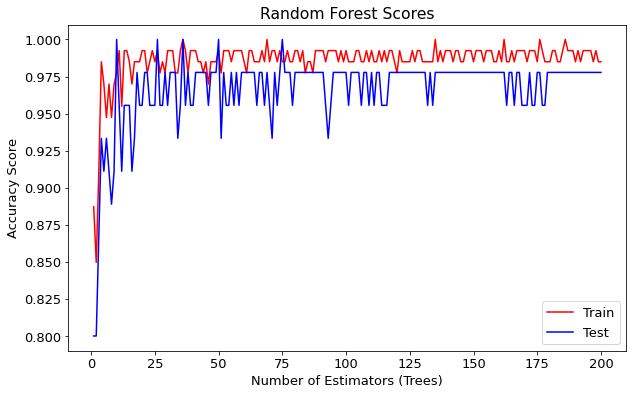

In [184]:
plt.figure(figsize=(10,6))
plt.plot(list(n_estimators), train_accs_rf, label = 'Train', c='red', )
plt.plot(list(n_estimators), test_accs_rf, label = 'Test', c = 'blue')
plt.xlabel('Number of Estimators (Trees)')
plt.ylabel('Accuracy Score')
plt.title('Random Forest Scores')
plt.legend();

#### It is typical that a Random Forest with more trees will return higher accuracy or MSE but with diminishing returns. 

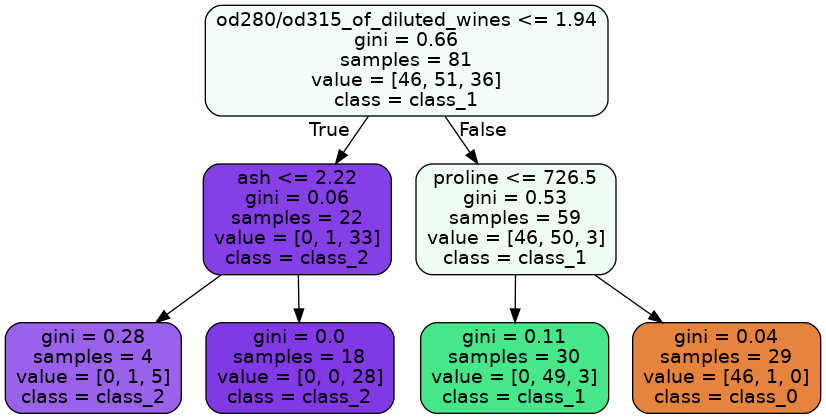

In [175]:
get_viz(rf.estimators_[0])

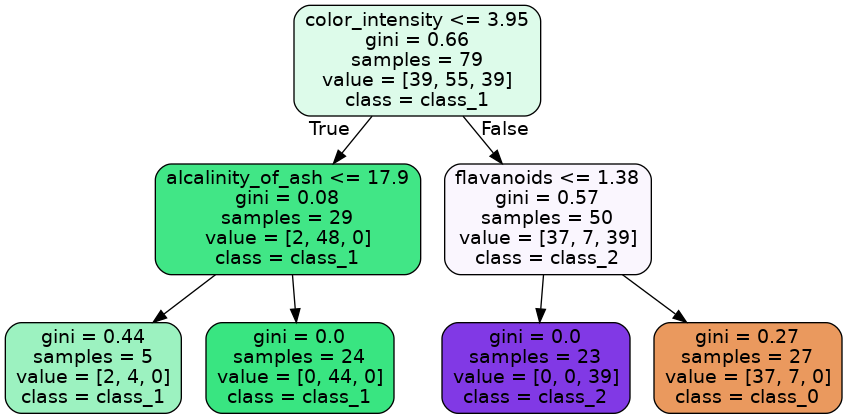

In [176]:
get_viz(rf.estimators_[4])

#### Questions

1. In a Random Forest, are features chosen at each tree or at each split?
1. When creating a Random Forest, how do you determine how many trees you should use?
1. Would Random Forest work for regression as well as classification problems, why?

### Parameters for Random Forest
1. n_estimators (number of trees)
1. max_features (number of features to consider at each split)
1. OOB_score (whether to use out of bag score to generalize accuracy/R^2)
1. Any Decision tree Parameter



#### OOB_score parameter explained
Each bootstrapped sample in the Random Forest classifier is trained on slightly different data and for each Decision Tree within the Random Forest, we have a holdout set called **"out of bag sample"**.


These samples will be predicted on for the other Decision Trees that did not contain the specific sample. The final prediction of a row is determined by the "majority vote" or "mean" of all available DT predictions. The OOB score is computed as the number of correctly predicted rows from the out of bag sample.


### Random Forest Strengths and Weaknesses

Pros:
1. No need for feature scaling
1. works for nonlinear relationships
1. Typically has great performance

Cons:
1. expensive to train
1. not as interpretable as other models we have learned

### Work with Feature Importance

Yes, Random Forest Models are not highly interpretable, however, we can begin to hilight more important features through evaluation of 

## What is a random forest?

What if, instead of making one decision tree, you made several? As many as you wanted, really—a whole forest. And what if each tree in the forest got a vote on the outcome for a given observation? Then you'd have a new model type: random forest. Random forests have become an incredibly popular technique for data scientists, because this method tends to be a top performer with low variance and high accuracy in a huge number of circumstances.

Much like decision trees, random forest can be used for both classification and regression problems. The main difference is how the votes are aggregated. As a classifier, the most popular outcome (the mode) is returned. And as a regression, it is typically the average (the mean) that is returned.


## Parameters

When building a random forest, you get to set parameters for both the tree and the forest. So for the tree, you have the same parameters as before: you can set the depth of the tree and the number of features used in each rule or split. You can also specify how the tree is built; you can use information gain and entropy like you did before, or you can use other methods, like [Gini impurity](https://www.garysieling.com/blog/sklearn-gini-vs-entropy-criteria).

You also get to control the number of estimators that you want to generate, or the number of trees in the forest. Here you have a tradeoff between how much variance you can explain and the computational complexity. This is pretty easily tunable. As you increase the number of trees in the forest, the accuracy should converge; eventually, the additional learning from another tree approaches zero. There isn't an infinite amount of information to learn; at some point, the trees have learned all they can. So when you have an acceptable variance in accuracy, you can stop adding trees. This becomes worthwhile when you're dealing with large datasets with many variables.

ADVANTAGES

    One of the most accurate learning algorithms available
    It can handle many predictor variables
    Provides estimates of the importance of different predictor variables
    Maintains accuracy even when a large proportion of the data is missing

LIMITATIONS

    Can overfit datasets that are particularly noisy
    For data including categorical predictor variables with different number of levels, random forests are biased in favor of those predictors with more levels. Therefore, the variable importance scores from random forest are not always reliable for this type of data


## Advantages and disadvantages of random forest

The biggest advantage of random forest is its tendency to be a very strong performer. It is reasonably accurate in a myriad of situations, from regression to classification. Some people [really love random forests](https://medium.com/rants-on-machine-learning/the-unreasonable-effectiveness-of-random-forests-f33c3ce28883#.rq8akkff1). However, it does have some disadvantages.

Firstly, in both classification and regression, it will not predict outside of the sample. This means that it will only return values that are within a range that it has seen before. Random forests can also get rather large and slow if you let them grow too wildly.

The biggest disadvantage, however, is the lack of transparency in the process. Random forest is often referred to as a *black-box model*; it provides an output but very little insight into how it got there. You'll run into a few more of these black-box models throughout the program.

Black-box models often make the more statistically minded data scientists nervous. You don't get much insight into the process. You can't see the rules that it's really applying, or what variables it's prioritizing, or how. You don't see any of the internal processes, and you don't get to look "inside the box." Therefore, you also can't represent that process in a simple visual form or learn about the underlying process. You have to trust in the algorithm building the trees and the lack of variance from a large number of them being generated. It usually works out pretty well, and you can of course evaluate the model via other methods to validate your conclusions.

In the next section, you'll walk through an example of the random forest classifier.


ASSUMPTIONS

No formal distributional assumptions, random forests are non-parametric and can thus handle skewed and multi-modal data as well as categorical data that are ordinal or non-ordinal.